In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load and Preprocess Data

# Load Bitcoin historical data
crypto_df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\coin_Bitcoin.csv")

# Load Macroeconomic Indicators data
macro_df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\economic_indicators.csv")

# Convert Date columns to datetime format
crypto_df['Date'] = pd.to_datetime(crypto_df['Date'])
macro_df['Date'] = pd.to_datetime(macro_df['Date'])

# Drop 'SNo' column if it exists (it does not add analytical value)
crypto_df.drop(columns=['SNo'], inplace=True, errors='ignore')


In [2]:
# Preprocessing

# Resample Cryptocurrency Data to Monthly Frequency

# Select only numeric columns for resampling
numeric_columns = crypto_df.select_dtypes(include=['number']).columns

# Resample the dataset to monthly frequency (ME = Month End)
crypto_df = crypto_df.set_index('Date').resample('ME')[numeric_columns].mean().reset_index()

# Merge Cryptocurrency Data with Macroeconomic Data

# Merge datasets on 'Date' using a left join
merged_df = pd.merge(crypto_df, macro_df, on='Date', how='left')

# Handle missing values using forward fill (ffill ensures consistent data)
merged_df.ffill(inplace=True)

In [5]:
# Select Key Countries for Analysis

# Define selected countries for a balanced, in-depth analysis
selected_countries = ['USA', 'China', 'Germany', 'UK', 'India']

# Drop 'Unemployment Rate (%)' as it is less relevant to Bitcoin price movements
merged_df.drop(columns=['Unemployment Rate (%)'], inplace=True, errors='ignore')

# Filter dataset for the selected countries only
merged_df = merged_df[merged_df['Country'].isin(selected_countries)]

# Save merged dataset BEFORE feature engineering
merged_df.to_csv(r"C:\Users\vaish\OneDrive\UH\Project\merged_crypto_macro_data.csv", index=False)
print("Merged dataset saved successfully!")

Merged dataset saved successfully!


Feature engineering completed! Processed dataset saved successfully!


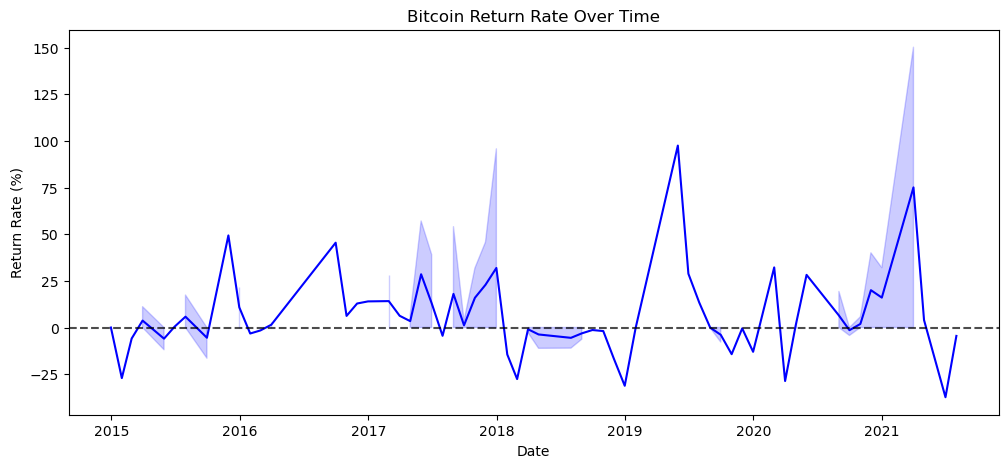

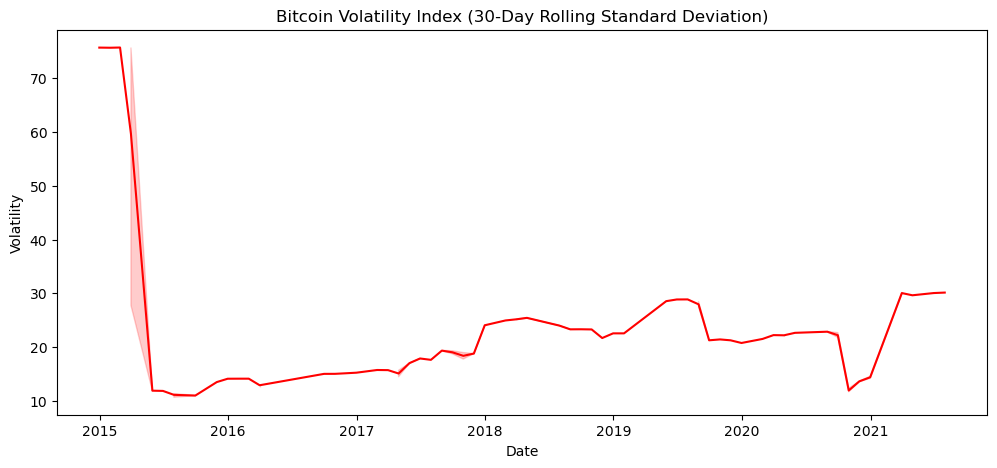

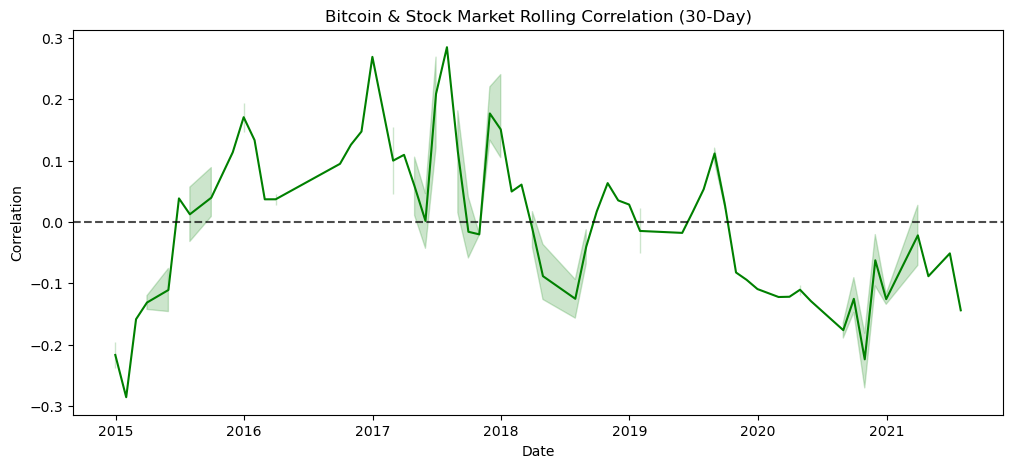

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Merged Dataset & Convert Date Column

# Load the merged dataset (before feature engineering)
df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\merged_crypto_macro_data.csv")

# Convert 'Date' column to datetime and set as index for visualization
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 2. Feature Engineering

# Bitcoin Return Rate (Daily Percentage Change)
df['Bitcoin_Return_Rate'] = df['Close'].pct_change() * 100

# Volatility Index (Rolling Standard Deviation of Returns over 30 days)
df['Volatility_Index'] = df['Bitcoin_Return_Rate'].rolling(window=30).std()

# Rolling Correlation (Bitcoin vs Stock Market Index over 30 days)
if 'Stock Index Value' in df.columns:
    df['Rolling_Correlation'] = df['Close'].rolling(window=30).corr(df['Stock Index Value'])
else:
    df['Rolling_Correlation'] = np.nan  # Assign NaN if Stock Index column is missing

# Drop NaN values generated by rolling calculations (first 30 rows)
df.dropna(inplace=True)

# Save the feature-engineered dataset
df.to_csv(r"C:\Users\vaish\OneDrive\UH\Project\processed_crypto_macro_data.csv", index=True)

print("Feature engineering completed! Processed dataset saved successfully!")

# 3. Visualization of Engineered Features

# Bitcoin Return Rate Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(x=df.index, y=df['Bitcoin_Return_Rate'], color='blue')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title("Bitcoin Return Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Return Rate (%)")
plt.show()

# Bitcoin Volatility Index (30-Day Rolling Standard Deviation)
plt.figure(figsize=(12, 5))
sns.lineplot(x=df.index, y=df['Volatility_Index'], color='red')
plt.title("Bitcoin Volatility Index (30-Day Rolling Standard Deviation)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

# Bitcoin & Stock Market Rolling Correlation (30-Day)
if 'Stock Index Value' in df.columns:
    plt.figure(figsize=(12, 5))
    sns.lineplot(x=df.index, y=df['Rolling_Correlation'], color='green')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    plt.title("Bitcoin & Stock Market Rolling Correlation (30-Day)")
    plt.xlabel("Date")
    plt.ylabel("Correlation")
    plt.show()

In [9]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the processed dataset
df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\processed_crypto_macro_data.csv")

# Define features (X) and target variable (y)
features = ['Inflation Rate (%)', 'GDP Growth Rate (%)', 'Interest Rate (%)', 
            'Stock Index Value', 'Bitcoin_Return_Rate', 'Volatility_Index', 'Rolling_Correlation']

target = 'Close'  # Bitcoin closing price

X = df[features]
y = df[target]

# Split dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardize the feature set (Required for SVM & LSTM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preparation complete!")

Data preparation complete!


In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Load Processed Data & Prepare Features

# Load the processed dataset
df = pd.read_csv(r"C:\Users\vaish\OneDrive\UH\Project\processed_crypto_macro_data.csv")

# Define features & target
features = ['Inflation Rate (%)', 'GDP Growth Rate (%)', 'Interest Rate (%)', 
            'Stock Index Value', 'Bitcoin_Return_Rate', 'Volatility_Index', 'Rolling_Correlation']
target = 'Close'  # Bitcoin closing price

X = df[features]  # Independent variables
y = df[target]  # Target variable

# Split dataset into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Standardize features (SVM is sensitive to feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Train SVM Model

# Define Support Vector Regressor (SVR) with RBF Kernel
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred_svm = svm_model.predict(X_test_scaled)

# 3. Evaluate Model Performance

# Store performance metrics for later comparison
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mape_svm = np.mean(np.abs((y_test - y_pred_svm) / y_test)) * 100

# Print results
print("SVM Model Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse_svm:.2f}")
print(f"Mean Absolute Error (MAE): {mae_svm:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_svm:.2f}%")

# Compute actual & predicted price directions for SVM
actual_direction_svm = np.sign(np.diff(y_test))  # 1 if price increased, -1 if decreased
predicted_direction_svm = np.sign(np.diff(y_pred_svm))

# Compute Directional Accuracy
directional_accuracy_svm = np.mean(actual_direction_svm == predicted_direction_svm) * 100

# Print Directional Accuracy
print(f"SVM Directional Accuracy: {directional_accuracy_svm:.2f}%")

SVM Model Performance:
Root Mean Squared Error (RMSE): 21928.53
Mean Absolute Error (MAE): 15918.65
Mean Absolute Percentage Error (MAPE): 70.57%
SVM Directional Accuracy: 8.70%
